In [184]:
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import os
import sys
import scvelo as scv
scv.settings.verbosity=1
import scvi
from tqdm.notebook import tqdm
from pathlib import Path

# Jupyter stuff
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

# Paths and utils
root = Path('../../')
figure_path = root / 'results/figures/'
table_path = root / 'results/tables/'
data_path = root / 'data/'
# BIH
tmp_path = Path('/fast/scratch/users/peidlis_c/')
utils_path = Path('/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/')
# local
tmp_path = data_path
utils_path = '/Users/stefanpeidli/work/utils/scrnaseq_utils/'

sys.path.insert(1, utils_path)
from scrnaseq_util_functions import *

%matplotlib inline

In [185]:
import gseapy as gp

In [192]:
def extract_gsea_results(prerank_object):
    # prepare data
    Y = prerank_object.res2d.copy()
    
    # clear names
    Y['source']=None
    Y['Enrichment_Term']=None
    for index, row in Y.iterrows():
        for gene_set in gene_sets:
            if gene_set in row.Term:
                Y.loc[index, 'source'] = gene_set
                Y.loc[index, 'Enrichment_Term'] = row.Term.replace('__', '_').replace(gene_set+'_', '')
    
    Y = Y.sort_values('NES')
    y = -np.log10(Y['FDR q-val'].astype(float))
    Y['score'] = np.clip(y, 0, np.max(y[y!=np.infty]))
    Y['significance_str'] = format_pvals(Y['FDR q-val'])
    return Y

keywords = ['infection', 'sars', 'covid', 'corona', 'innate', 'immune', 'cytokine', 'interferon', 
            'tgf', 'MTOR', 'Lung', 'neutro', 'apoptosis', 'hypoxia', 'nod-like' 'inflamm',
           'DNA-sensing', 'calcium', 'influenza', 'hepatitis', 'jak', 'stat', 'il-', 'virus']

def Uplot(prerank_object, ax=None):
    ax = pl.subplots(figsize=(8,6))[-1] if ax is None else ax
    
    Y = extract_gsea_results(prerank_object)
    
    sns.scatterplot(data=Y, x='NES', y='score', ax=ax, hue='source', hue_order=np.sort(Y.source.unique()))
    
    # annotate
    for index, row in Y.iterrows():
        if row['FDR q-val'] < .05 and any([k.lower() in row.Term.lower() for k in keywords]):
            x = row.NES
            y = row.score
            ax.annotate(row.Enrichment_Term, (x, y), xytext=(x+0.4, y), arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"), fontsize=5)
    ax.set_xlim(-2.5, 2.5)
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    ax.axhline(-np.log10(0.05), label=r'$\alpha=0.05$')
    ax.legend(title='GSEA\nSignificance')#, bbox_to_anchor=(1,0.5))

    ax.set_xlabel(f'GSEA Normalized Enrichment Score')
    ax.set_ylabel('-Log10(q-value)', loc='top')

# Dataset selection

In [187]:
# Options
gene_sets=["KEGG_2021_Human", 'MSigDB_Hallmark_2020'] #, 'WikiPathway_2021_Human']
celltype = 'Allcelltypes'
datasets = ['Dwarfhamster_hd', 'Dwarfhamster_ld', 'Goldhamster', 'ChuaEils', 'MelmsIzar']
key = 'infection'

# load deseq results
dfs =[pd.read_csv(root / f'results/DESeq2/infection/{celltype}_{d}_COVID19_vs_healthy.csv', index_col=0) for d in datasets]
# humanize hamster genes
for i, df_ in enumerate(dfs):
    ds = datasets[i]
    if 'hamster' in ds:
        df_.index = specify_genes(df_.index, 'mouse', 'human')  # map to human using biomart
        df_ = df_[~df_.index.duplicated(keep='first')]  # remove dups

In [193]:
def do_gsea(datasets, celltype, key, load_key, gene_sets=["KEGG_2021_Human", 'MSigDB_Hallmark_2020']):
    # load_key for key=severity: severity
    # load_key for key=infection: COVID19_vs_healthy
    
    # load deseq results
    dfs =[pd.read_csv(root / f'results/DESeq2/{key}/{celltype}_{d}_{load_key}.csv', index_col=0) for d in datasets]

    # humanize hamster genes
    for i, df_ in enumerate(dfs):
        ds = datasets[i]
        if 'hamster' in ds:
            df_.index = specify_genes(df_.index, 'mouse', 'human')  # map to human using biomart
            df_ = df_[~df_.index.duplicated(keep='first')]  # remove dups
    
    # GSEA for Pros:
    ranked_genes = []
    for i, df in enumerate(dfs):
        # Step 1: Filter by mean expression (low expression makes statistics unreliable)
        df = df[df.baseMean > 10]
        # Step 2: Compute the neglog10 of p-value without multiple testing correction 
        # (we only want an ordering, the correction might lead to more draws in ranking)
        df['score'] = - np.log10(df.pvalue)
        # Step 3: Add sign from lfc
        df['signed_score'] = df.score * np.sign(df.log2FoldChange)
        # Step 4: Use that to rank genes
        df = df[~df.signed_score.isna()].sort_values('signed_score', ascending=False)
        ranked_genes.append(df[['signed_score']])
    # run GSEA
    pre_res = []
    for d, rank in zip(datasets, ranked_genes):
        pre_res_ = gp.prerank(rnk=rank,
                             gene_sets=gene_sets,
                             threads=8,
                             min_size=15,
                             max_size=1000,
                             permutation_num=1000, # reduce number to speed up testing
                             outdir=None, # don't write to disk
                             seed=6,
                             verbose=False, # see what's going on behind the scenes
                            )
        pre_res.append(pre_res_)
        tab = pre_res_.res2d
        #tab.to_csv(f'{d}_{celltype}_{key}_all_GSEA.csv')
        tab[tab['FDR q-val']<0.05].sort_values('NES', ascending=False).to_csv(f'{d}_{celltype}_{key}_significant_GSEA.csv')
    
    return pre_res

2023-02-01 14:47:04,646 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-02-01 14:47:07,372 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-02-01 14:47:09,966 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


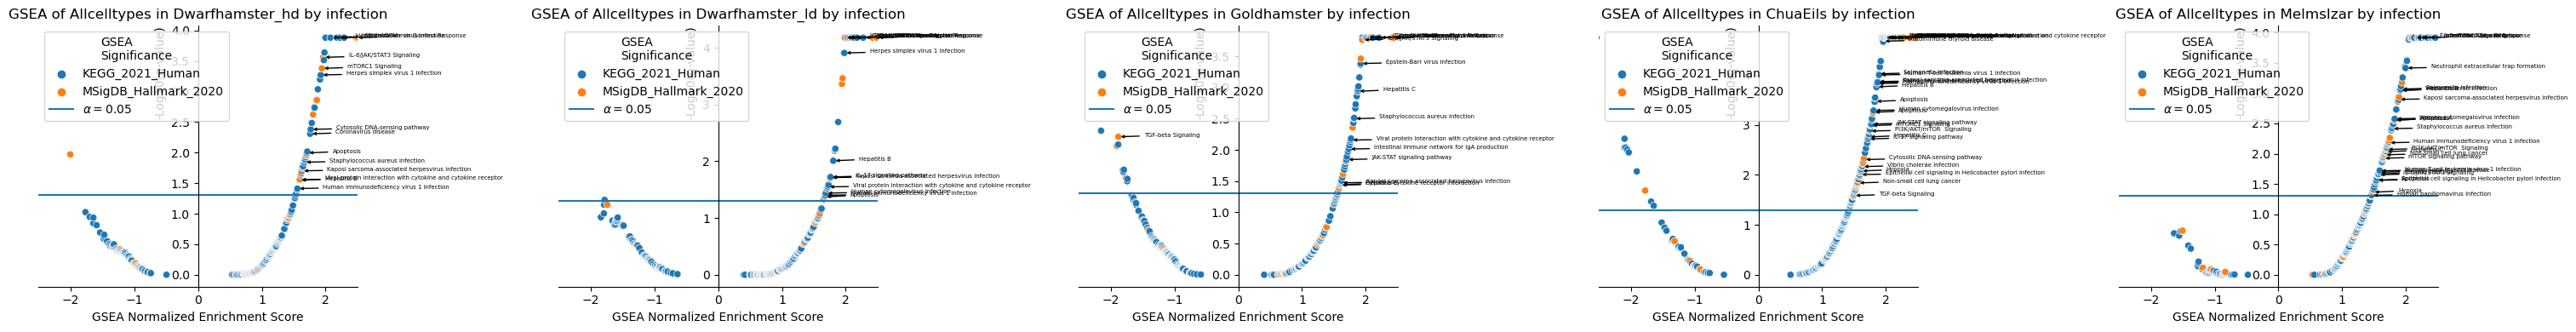

2023-02-01 14:47:21,793 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-02-01 14:47:21,797 [WARNING] Input gene rankings contains inf values!
2023-02-01 14:47:21,798 [WARNING] Duplicated values found in preranked stats: 4.49% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


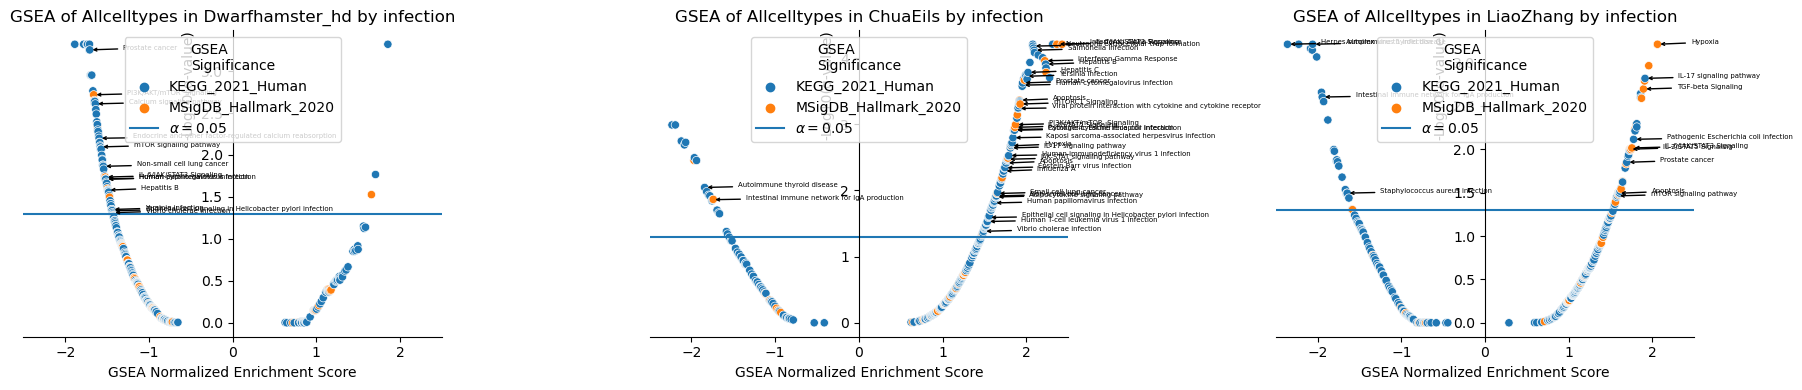

In [194]:
datasets=['Dwarfhamster_hd', 'Dwarfhamster_ld', 'Goldhamster', 'ChuaEils', 'MelmsIzar']
pre_res = do_gsea(datasets=datasets, celltype='Allcelltypes', key='infection', load_key='COVID19_vs_healthy')
N = len(datasets)
scale = 1
axs = pl.subplots(1, N, figsize=(6*N*scale,4*scale), sharey=False)[-1]
for i, ax in enumerate(axs):
    Uplot(pre_res[i], ax=ax)
    ax.set_title(f'GSEA of {celltype} in {datasets[i]} by {key}')
pl.tight_layout()
pl.show()

datasets=['Dwarfhamster_hd', 'ChuaEils', 'LiaoZhang']
pre_res = do_gsea(datasets=datasets, celltype='Allcelltypes', key='severity', load_key='severity')
N = len(datasets)
scale = 1
axs = pl.subplots(1, N, figsize=(6*N*scale,4*scale), sharey=False)[-1]
for i, ax in enumerate(axs):
    Uplot(pre_res[i], ax=ax)
    ax.set_title(f'GSEA of {celltype} in {datasets[i]} by {key}')
pl.tight_layout()
pl.s
pl.show()

# GSEA

In [179]:
# GSEA for Pros:
ranked_genes = []
for i, df in enumerate(dfs):
    # Step 1: Filter by mean expression (low expression makes statistics unreliable)
    df = df[df.baseMean > 10]
    # Step 2: Compute the neglog10 of p-value without multiple testing correction 
    # (we only want an ordering, the correction might lead to more draws in ranking)
    df['score'] = - np.log10(df.pvalue)
    # Step 3: Add sign from lfc
    df['signed_score'] = df.score * np.sign(df.log2FoldChange)
    # Step 4: Use that to rank genes
    df = df[~df.signed_score.isna()].sort_values('signed_score', ascending=False)
    ranked_genes.append(df[['signed_score']])

In [180]:
# run GSEA
pre_res = []
for d, rank in zip(datasets, ranked_genes):
    pre_res_ = gp.prerank(rnk=rank,
                         gene_sets=gene_sets,
                         threads=8,
                         min_size=15,
                         max_size=1000,
                         permutation_num=1000, # reduce number to speed up testing
                         outdir=None, # don't write to disk
                         seed=6,
                         verbose=True, # see what's going on behind the scenes
                        )
    pre_res.append(pre_res_)
    tab = pre_res_.res2d
    #tab.to_csv(f'{d}_{celltype}_{key}_all_GSEA.csv')
    tab[tab['FDR q-val']<0.05].sort_values('NES', ascending=False).to_csv(f'{d}_{celltype}_{key}_significant_GSEA.csv')

2023-01-31 19:22:36,962 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-01-31 19:22:36,966 [WARNING] Input gene rankings contains inf values!
2023-01-31 19:22:36,967 [WARNING] Duplicated values found in preranked stats: 4.49% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-01-31 19:22:36,967 [INFO] Parsing data files for GSEA.............................
2023-01-31 19:22:36,968 [INFO] Enrichr library gene sets already downloaded in: /Users/stefanpeidli/.cache/gseapy, use local file
2023-01-31 19:22:36,972 [INFO] Enrichr library gene sets already downloaded in: /Users/stefanpeidli/.cache/gseapy, use local file
2023-01-31 19:22:36,980 [INFO] 0026 gene_sets have been filtered out when max_size=1000 and min_size=15
2023-01-31 19:22:36,981 [INFO] 0344 gene_sets used for further statistical testing.....
2023-01-31 19:22:36,981 [INFO] Start to run GSEA...Might take a while...............

# Plots

## Uplots

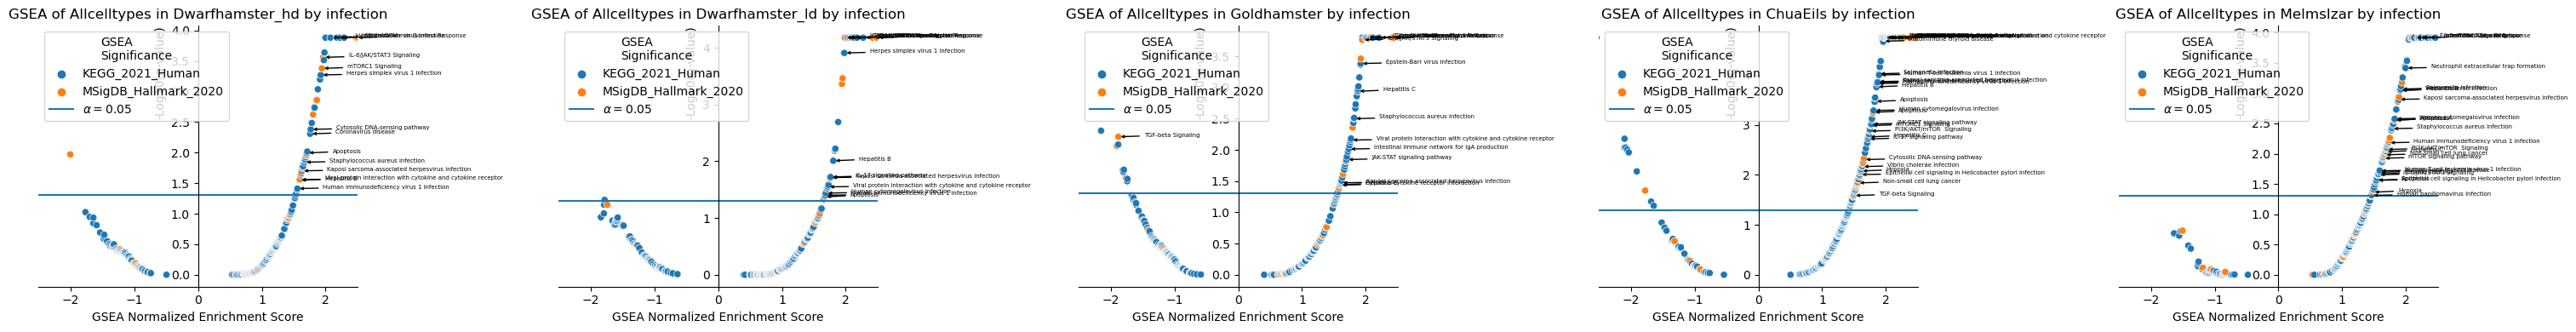

In [177]:
N = len(datasets)
scale = 1
axs = pl.subplots(1, N, figsize=(6*N*scale,4*scale), sharey=False)[-1]

for i, ax in enumerate(axs):
    Uplot(pre_res[i], ax=ax)
    ax.set_title(f'GSEA of {celltype} in {datasets[i]} by {key}')
pl.tight_layout()
pl.show()

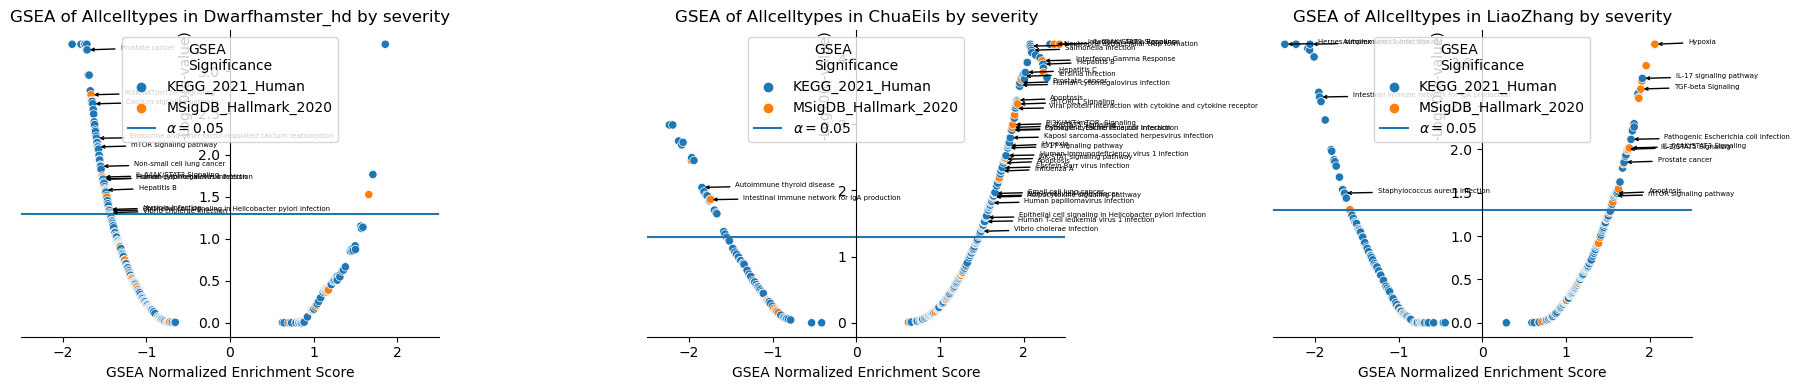

In [183]:
N = len(datasets)
scale = 1
axs = pl.subplots(1, N, figsize=(6*N*scale,4*scale), sharey=False)[-1]

for i, ax in enumerate(axs):
    Uplot(pre_res[i], ax=ax)
    ax.set_title(f'GSEA of {celltype} in {datasets[i]} by {key}')
pl.tight_layout()
pl.show()

## Bars

In [140]:
def plot_GSEA_bars(prerank_object, ax=None):
    ax = pl.subplots(figsize=(8,6))[-1] if ax is None else ax
    
    Y = extract_gsea_results(prerank_object)

    mask = Y.significance_str!='ns'
    sns.barplot(data=Y[mask], y='NES', x='Term', hue='source', dodge=False, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [144]:
Y = extract_gsea_results(pre_res[0])
Y[Y.significance_str!='ns'].Enrichment_Term

6                                        UV Response Dn
60                          Arachidonic acid metabolism
58                                            Phagosome
57             Human immunodeficiency virus 1 infection
56    Viral protein interaction with cytokine and cy...
55                                          Hepatitis B
54                                          p53 Pathway
52                            Oxidative Phosphorylation
51                           Osteoclast differentiation
50                                        Leishmaniasis
49                                          Coagulation
48      Kaposi sarcoma-associated herpesvirus infection
47                                       Myc Targets V1
46          Protein processing in endoplasmic reticulum
45                                           Glycolysis
44                                    Alzheimer disease
41                                          Necroptosis
40                                             L

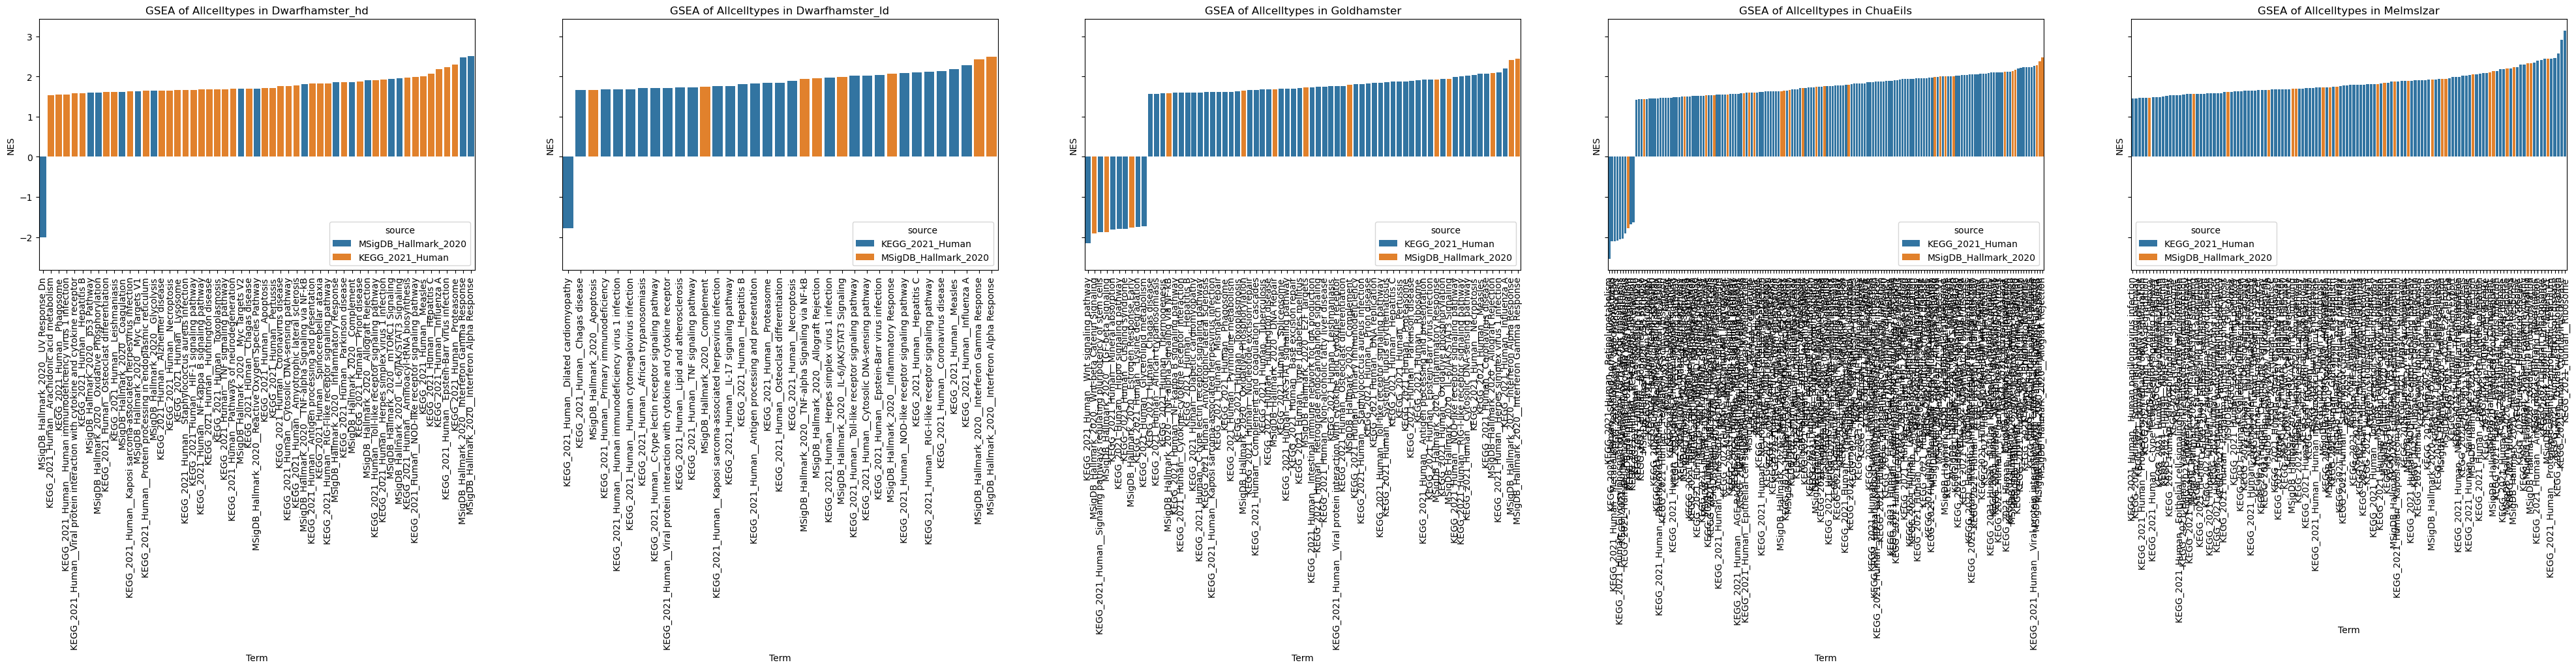

In [141]:
N = len(datasets)
scale = 1
axs = pl.subplots(1, N, figsize=(10*N*scale,5*scale), sharey=True)[-1]

for i, ax in enumerate(axs):
    plot_GSEA_bars(pre_res[i], ax=ax)
    ax.set_title(f'GSEA of {celltype} in {datasets[i]}')
pl.tight_layout()
pl.show()

# VS plot (dysfunct)

In [39]:
# Aggregate
D1 = pre_res[0].res2d.copy()
D1.columns = ['Name', 'Term'] + [c+'_'+datasets[0] for c in D1.columns[2:]]
D2 = pre_res[1].res2d.copy()
D2.columns = ['Name', 'Term'] + [c+'_'+datasets[1] for c in D2.columns[2:]]

D = pd.merge(D1, D2, left_on='Term', right_on='Term', how='inner')
#D = D.fillna(0)

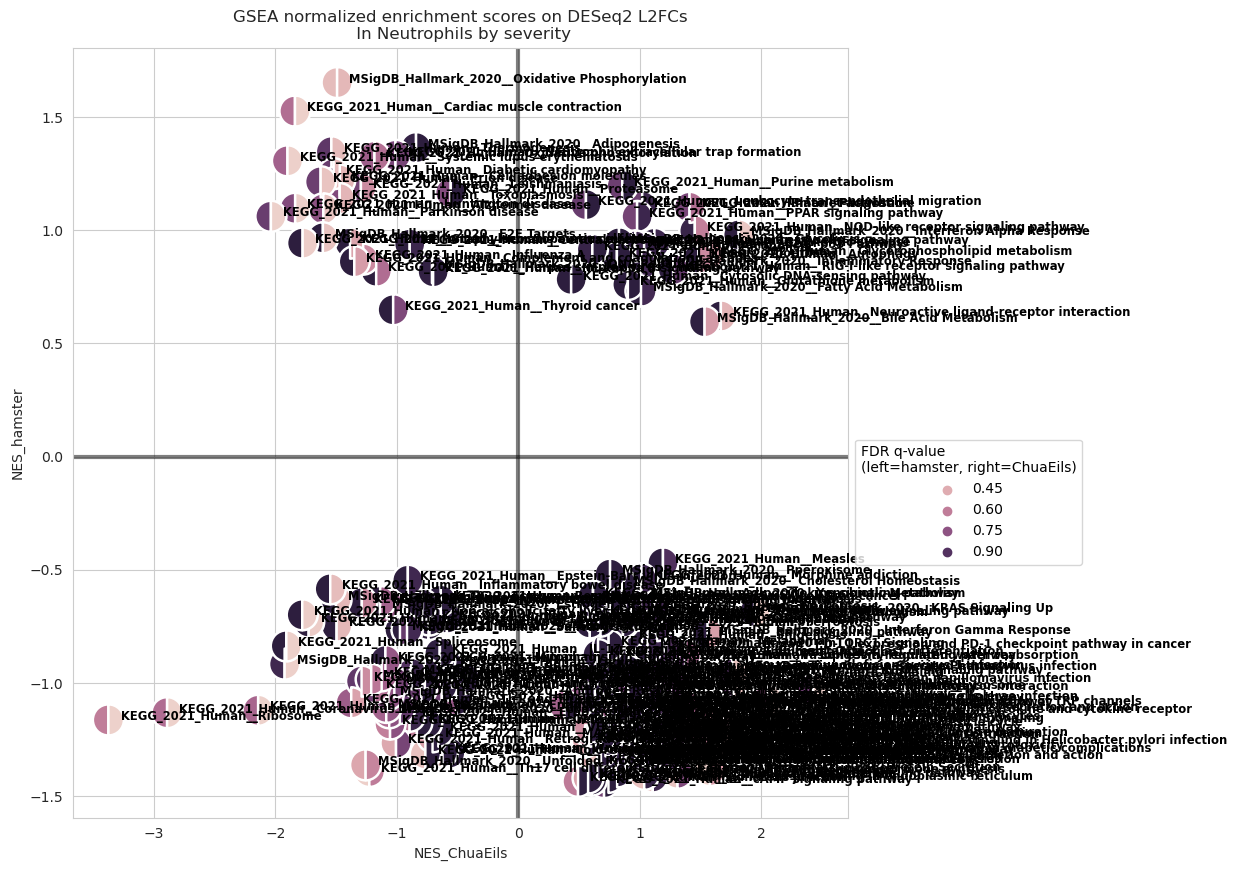

In [40]:
from matplotlib.markers import MarkerStyle

y = f'NES_{datasets[0]}'
x = f'NES_{datasets[1]}'

with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(1,1, figsize=[10,10])
sns.scatterplot(data=D, x=x, y=y, marker=MarkerStyle("o", fillstyle="left"), 
                s=500, hue=f'FDR q-val_{datasets[0]}')
sns.scatterplot(data=D, x=x, y=y, marker=MarkerStyle("o", fillstyle="right"), 
                s=500, hue=f'FDR q-val_{datasets[1]}', legend=False)
ax.legend(title=f'FDR q-value\n(left={datasets[0]}, right={datasets[1]})')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,.5))
texts = []
for idx, row in D.iterrows():
     texts.append(ax.text(row[x]+0.1, row[y], row['Term'], horizontalalignment='left', size='small', color='black', weight='semibold'))
ax.axvline(0, linewidth=3, c='k', alpha=0.5)
ax.axhline(0, linewidth=3, c='k', alpha=0.5)
ax.set_title(f'GSEA normalized enrichment scores on DESeq2 L2FCs\n In {celltype} by {key}')

pl.savefig(figure_path / f'GSEA_moons_{celltype}_{datasets[0]}_and_{datasets[1]}_by_{key}.pdf', bbox_inches='tight')
pl.show()

In [41]:
alpha = 0.05
D_ = D[(D['FDR q-val_gold']<alpha) | (D['FDR q-val_dwarf_hd']<alpha)]

KeyError: 'FDR q-val_gold'

NameError: name 'D_' is not defined

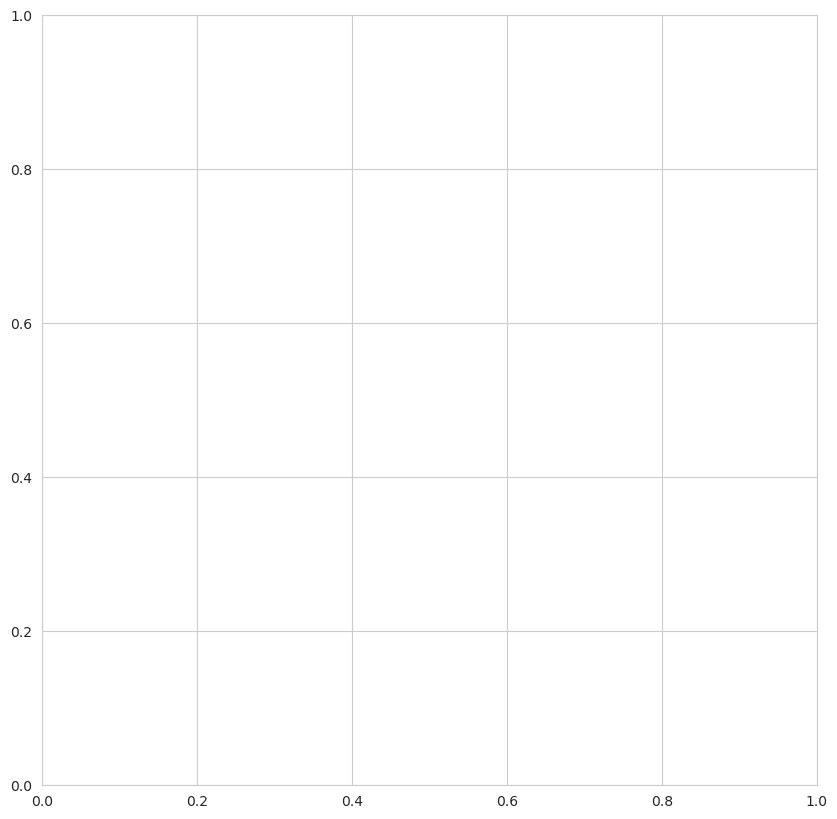

In [43]:
from matplotlib.markers import MarkerStyle

y = f'NES_{datasets[0]}'
x = f'NES_{datasets[1]}'

with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(1,1, figsize=[10,10])
sns.scatterplot(data=D_, x=x, y=y, marker=MarkerStyle("o", fillstyle="left"), 
                s=500, hue=f'FDR q-val_{dataset1}')
sns.scatterplot(data=D_, x=x, y=y, marker=MarkerStyle("o", fillstyle="right"), 
                s=500, hue=f'FDR q-val_{dataset2}', legend=False)
ax.legend(title=f'FDR q-value\n(left={dataset1}, right={dataset2})')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,.5))
texts = []
for idx, row in D_.iterrows():
     texts.append(ax.text(row[x]+0.1, row[y], row['Term'], horizontalalignment='left', size='small', color='black', weight='semibold'))
ax.axvline(0, linewidth=3, c='k', alpha=0.5)
ax.axhline(0, linewidth=3, c='k', alpha=0.5)
ax.set_title(f'GSEA normalized enrichment scores on DESeq2 L2FCs\n In {celltype} by {key}')

pl.savefig(figure_path / f'GSEA_moons_{celltype}_{dataset1}_and_{dataset2}_by_{key}.pdf', bbox_inches='tight')
pl.show()

# Spacers